# Klasifikasi Text Mining menggunakan Naive Bayes & KNN

## install library ekphrasis

In [1]:
!pip install ekphrasis

In [2]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

C:\Users\User\anaconda3\lib\site-packages\ekphrasis\classes\tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading twitter - 1grams ...
Reading twitter - 2grams ...


C:\Users\User\anaconda3\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


## load library

In [3]:
import re
import string 
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

## load dataset

In [4]:
df = pd.read_csv('dataset_tweet_sentiment_cellular_service_provider.csv')

In [5]:
df.head()

,Id,Sentiment,Text Tweet
0,1,positive,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...
1,2,positive,"Saktinya balik lagi, alhamdulillah :v <PROVIDE..."
2,3,negative,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...
3,4,negative,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...
4,5,negative,Selamat malam PENDUSTA <PROVIDER_NAME>


In [6]:
map = {'negative':0,'positive':1}
df.replace({'Sentiment' : map},inplace = True)

In [7]:
df.head()

,Id,Sentiment,Text Tweet
0,1,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...
1,2,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE..."
2,3,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...
3,4,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...
4,5,0,Selamat malam PENDUSTA <PROVIDER_NAME>


In [8]:
df = df.drop(['Id'], axis=1)

In [9]:
df.head()

,Sentiment,Text Tweet
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE..."
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>


## Preprocessing

### Setting fungsi

In [10]:
def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))

def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text) 

### Running Preprocessing 

In [11]:
final_string = []
for text in df['Text Tweet'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc) 
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

In [12]:
df["step01"] = final_string

In [13]:
df.head(1)

,Sentiment,Text Tweet,step01
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,user_mention hashtag boikot hashtag provider_n...


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentiment   300 non-null    int64 
 1   Text Tweet  300 non-null    object
 2   step01      300 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.2+ KB


### hapus record yang kosong 

In [15]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [16]:
df_new = df[~df.isin(df_hapus)].dropna()

In [17]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Sentiment   300 non-null    int64 
 1   Text Tweet  300 non-null    object
 2   step01      300 non-null    object
dtypes: int64(1), object(2)
memory usage: 7.2+ KB


### normalisasi kata slang

In [18]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [20]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [21]:
df_new.head(10)

,Sentiment,Text Tweet,step01,tokens
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,user_mention hashtag boikot hashtag provider_n...,"[user_mention, hashtag, boikot, hashtag, provi..."
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",saktinya balik lagi alhamdulillah provider_name,"[saktinya, balik, lagi, alhamdulillah, provide..."
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi provider_name bisa bantu kenapa d...,"[selamat, pagi, provider_name, bisa, bantu, ke..."
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear provider_name akhir2 ini jaringan data le...,"[dear, provider_name, akhir2, ini, jaringan, d..."
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam allcaps pendusta allcaps provide...,"[selamat, malam, allcaps, pendusta, allcaps, p..."
5,0,Untuk penembakan paket dari <PRODUCT_NAME> mas...,untuk penembakan paket dari product_name masih...,"[untuk, penembakan, paket, dari, product_name,..."
6,1,"<PROVIDER_NAME> aku pakai <PROVIDER_NAME>, pa...",provider_name aku pakai provider_name paket pr...,"[provider_name, aku, pakai, provider_name, pak..."
7,0,RT <USER_MENTION>: <PROVIDER_NAME> tak ada lag...,rt user_mention provider_name tak ada lagi dal...,"[rt, user_mention, provider_name, tak, ada, la..."
8,0,keluhan gak ditanggapi. bikin emosi aja. pulsa...,keluhan gak ditanggapi bikin emosi aja pulsaku...,"[keluhan, gak, ditanggapi, bikin, emosi, aja, ..."
9,0,#Bilboard iklan <PROVIDER_NAME> kok ada pesan ...,hashtag bilboard hashtag iklan provider_name k...,"[hashtag, bilboard, hashtag, iklan, provider_n..."


In [22]:
normalized_word = pd.read_excel("kamus perbaikan kata.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

In [23]:
df_new.head()

,Sentiment,Text Tweet,step01,tokens,tokens_perbaikan
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,user_mention hashtag boikot hashtag provider_n...,"[user_mention, hashtag, boikot, hashtag, provi...","[user_mention, hashtag, boikot, hashtag, provi..."
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",saktinya balik lagi alhamdulillah provider_name,"[saktinya, balik, lagi, alhamdulillah, provide...","[saktinya, balik, lagi, syukur, provider_name]"
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi provider_name bisa bantu kenapa d...,"[selamat, pagi, provider_name, bisa, bantu, ke...","[selamat, pagi, provider_name, bisa, bantu, ke..."
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear provider_name akhir2 ini jaringan data le...,"[dear, provider_name, akhir2, ini, jaringan, d...","[dear, provider_name, akhir2, ini, jaringan, d..."
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam allcaps pendusta allcaps provide...,"[selamat, malam, allcaps, pendusta, allcaps, p...","[selamat, malam, allcaps, pendusta, allcaps, p..."


In [24]:
df_new.iloc[0].tokens

['user_mention',
 'hashtag',
 'boikot',
 'hashtag',
 'provider_name',
 'gunakan',
 'produk',
 'bangsa',
 'sendiri',
 'provider_name']

In [25]:
df_new.iloc[0].tokens_perbaikan

['user_mention',
 'hashtag',
 'boikot',
 'hashtag',
 'provider_name',
 'gunakan',
 'produk',
 'bangsa',
 'sendiri',
 'provider_name']

## Stopword - Menggunakan Modul NLTK

In [26]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Sentiment,Text Tweet,step01,tokens,tokens_perbaikan,Stop_removal
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,user_mention hashtag boikot hashtag provider_n...,"[user_mention, hashtag, boikot, hashtag, provi...","[user_mention, hashtag, boikot, hashtag, provi...","[user_mention, hashtag, boikot, hashtag, provi..."
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",saktinya balik lagi alhamdulillah provider_name,"[saktinya, balik, lagi, alhamdulillah, provide...","[saktinya, balik, lagi, syukur, provider_name]","[saktinya, syukur, provider_name]"
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi provider_name bisa bantu kenapa d...,"[selamat, pagi, provider_name, bisa, bantu, ke...","[selamat, pagi, provider_name, bisa, bantu, ke...","[selamat, pagi, provider_name, bantu, kamar, s..."
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear provider_name akhir2 ini jaringan data le...,"[dear, provider_name, akhir2, ini, jaringan, d...","[dear, provider_name, akhir2, ini, jaringan, d...","[dear, provider_name, akhir2, jaringan, data, ..."
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam allcaps pendusta allcaps provide...,"[selamat, malam, allcaps, pendusta, allcaps, p...","[selamat, malam, allcaps, pendusta, allcaps, p...","[selamat, malam, allcaps, pendusta, allcaps, p..."
...,...,...,...,...,...,...
295,1,"Pantesan lancar ya, sinyal <PROVIDER_NAME> yan...",pantesan lancar ya sinyal provider_name yang 4...,"[pantesan, lancar, ya, sinyal, provider_name, ...","[pantesan, lancar, iya, sinyal, provider_name,...","[pantesan, lancar, iya, sinyal, provider_name,..."
296,1,Alhamdulillah lancar pakai <PROVIDER_NAME>,alhamdulillah lancar pakai provider_name,"[alhamdulillah, lancar, pakai, provider_name]","[syukur, lancar, pakai, provider_name]","[syukur, lancar, pakai, provider_name]"
297,1,"Untung pakai internet <PROVIDER_NAME>, lancar,...",untung pakai internet provider_name lancar jad...,"[untung, pakai, internet, provider_name, lanca...","[untung, pakai, internet, provider_name, lanca...","[untung, pakai, internet, provider_name, lanca..."
298,1,"di tempat ramai seperti di lokasi wisata, <PRO...",di tempat ramai seperti di lokasi wisata provi...,"[di, tempat, ramai, seperti, di, lokasi, wisat...","[di, tempat, ramai, seperti, di, lokasi, wisat...","[ramai, lokasi, wisata, provider_name, jaya]"


In [28]:
df_new.iloc[0].tokens_perbaikan

['user_mention',
 'hashtag',
 'boikot',
 'hashtag',
 'provider_name',
 'gunakan',
 'produk',
 'bangsa',
 'sendiri',
 'provider_name']

In [29]:
df_new.iloc[0].Stop_removal

['user_mention',
 'hashtag',
 'boikot',
 'hashtag',
 'provider_name',
 'produk',
 'bangsa',
 'provider_name']

In [30]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [31]:
df_new["step02"] = final_string_tokens

In [32]:
df_new.head()

,Sentiment,Text Tweet,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,user_mention hashtag boikot hashtag provider_n...,"[user_mention, hashtag, boikot, hashtag, provi...","[user_mention, hashtag, boikot, hashtag, provi...","[user_mention, hashtag, boikot, hashtag, provi...",user_mention hashtag boikot hashtag provider_n...
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",saktinya balik lagi alhamdulillah provider_name,"[saktinya, balik, lagi, alhamdulillah, provide...","[saktinya, balik, lagi, syukur, provider_name]","[saktinya, syukur, provider_name]",saktinya syukur provider_name
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi provider_name bisa bantu kenapa d...,"[selamat, pagi, provider_name, bisa, bantu, ke...","[selamat, pagi, provider_name, bisa, bantu, ke...","[selamat, pagi, provider_name, bantu, kamar, s...",selamat pagi provider_name bantu kamar sinyal ...
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear provider_name akhir2 ini jaringan data le...,"[dear, provider_name, akhir2, ini, jaringan, d...","[dear, provider_name, akhir2, ini, jaringan, d...","[dear, provider_name, akhir2, jaringan, data, ...",dear provider_name akhir2 jaringan data lemot ...
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam allcaps pendusta allcaps provide...,"[selamat, malam, allcaps, pendusta, allcaps, p...","[selamat, malam, allcaps, pendusta, allcaps, p...","[selamat, malam, allcaps, pendusta, allcaps, p...",selamat malam allcaps pendusta allcaps provide...


## Stemming - Menggunakan Sastrawi

In [33]:
!pip install sastrawi

In [34]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [35]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)
    
    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [36]:
df_new["ProcessedText"] = final_string

In [37]:
df_new.head(10)

,Sentiment,Text Tweet,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,1,<USER_MENTION> #BOIKOT_<PROVIDER_NAME> Gunakan...,user_mention hashtag boikot hashtag provider_n...,"[user_mention, hashtag, boikot, hashtag, provi...","[user_mention, hashtag, boikot, hashtag, provi...","[user_mention, hashtag, boikot, hashtag, provi...",user_mention hashtag boikot hashtag provider_n...,user mention hashtag boikot hashtag provider n...
1,1,"Saktinya balik lagi, alhamdulillah :v <PROVIDE...",saktinya balik lagi alhamdulillah provider_name,"[saktinya, balik, lagi, alhamdulillah, provide...","[saktinya, balik, lagi, syukur, provider_name]","[saktinya, syukur, provider_name]",saktinya syukur provider_name,sakti syukur provider name
2,0,Selamat pagi <PROVIDER_NAME> bisa bantu kenap...,selamat pagi provider_name bisa bantu kenapa d...,"[selamat, pagi, provider_name, bisa, bantu, ke...","[selamat, pagi, provider_name, bisa, bantu, ke...","[selamat, pagi, provider_name, bantu, kamar, s...",selamat pagi provider_name bantu kamar sinyal ...,selamat pagi provider name bantu kamar sinyal ...
3,0,Dear <PROVIDER_NAME> akhir2 ini jaringan data ...,dear provider_name akhir2 ini jaringan data le...,"[dear, provider_name, akhir2, ini, jaringan, d...","[dear, provider_name, akhir2, ini, jaringan, d...","[dear, provider_name, akhir2, jaringan, data, ...",dear provider_name akhir2 jaringan data lemot ...,dear provider name akhir2 jaring data lot bang...
4,0,Selamat malam PENDUSTA <PROVIDER_NAME>,selamat malam allcaps pendusta allcaps provide...,"[selamat, malam, allcaps, pendusta, allcaps, p...","[selamat, malam, allcaps, pendusta, allcaps, p...","[selamat, malam, allcaps, pendusta, allcaps, p...",selamat malam allcaps pendusta allcaps provide...,selamat malam allcaps dusta allcaps provider name
5,0,Untuk penembakan paket dari <PRODUCT_NAME> mas...,untuk penembakan paket dari product_name masih...,"[untuk, penembakan, paket, dari, product_name,...","[untuk, penembakan, paket, dari, product_name,...","[penembakan, paket, product_name, gangguan, iy...",penembakan paket product_name gangguan iya pro...,tembak paket product name ganggu iya provider ...
6,1,"<PROVIDER_NAME> aku pakai <PROVIDER_NAME>, pa...",provider_name aku pakai provider_name paket pr...,"[provider_name, aku, pakai, provider_name, pak...","[provider_name, aku, pakai, provider_name, pak...","[provider_name, pakai, provider_name, paket, p...",provider_name pakai provider_name paket produc...,provider name pakai provider name paket produc...
7,0,RT <USER_MENTION>: <PROVIDER_NAME> tak ada lag...,rt user_mention provider_name tak ada lagi dal...,"[rt, user_mention, provider_name, tak, ada, la...","[rt, user_mention, provider_name, tak, ada, la...","[rt, user_mention, provider_name, kamus, perha...",rt user_mention provider_name kamus perhapean ...,rt user mention provider name kamus perhapean ...
8,0,keluhan gak ditanggapi. bikin emosi aja. pulsa...,keluhan gak ditanggapi bikin emosi aja pulsaku...,"[keluhan, gak, ditanggapi, bikin, emosi, aja, ...","[keluhan, tidak, ditanggapi, membuat, emosi, s...","[keluhan, ditanggapi, emosi, pulsaku, dicuri, ...",keluhan ditanggapi emosi pulsaku dicuri soak d...,keluh tanggap emosi pulsa curi soak deh pulsa ...
9,0,#Bilboard iklan <PROVIDER_NAME> kok ada pesan ...,hashtag bilboard hashtag iklan provider_name k...,"[hashtag, bilboard, hashtag, iklan, provider_n...","[hashtag, bilboard, hashtag, iklan, provider_n...","[hashtag, bilboard, hashtag, iklan, provider_n...",hashtag bilboard hashtag iklan provider_name p...,hashtag bilboard hashtag iklan provider name p...


### simpan hasil preprocessing

In [38]:
df_new.to_csv('clean_dataset_part02.csv',sep=";")

## Penataan Data

### pembagian fitur dan label

In [39]:
import pandas as pd
import numpy as np

In [40]:
dataset = pd.read_csv('clean_dataset_part02.csv',sep=";")

In [41]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        300 non-null    int64 
 1   Sentiment         300 non-null    int64 
 2   Text Tweet        300 non-null    object
 3   step01            300 non-null    object
 4   tokens            300 non-null    object
 5   tokens_perbaikan  300 non-null    object
 6   Stop_removal      300 non-null    object
 7   step02            300 non-null    object
 8   ProcessedText     300 non-null    object
dtypes: int64(2), object(7)
memory usage: 21.2+ KB


In [42]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [43]:
dataset_feature.head(10)

0    user mention hashtag boikot hashtag provider n...
1                           sakti syukur provider name
2    selamat pagi provider name bantu kamar sinyal ...
3    dear provider name akhir2 jaring data lot bang...
4    selamat malam allcaps dusta allcaps provider name
5    tembak paket product name ganggu iya provider ...
6    provider name pakai provider name paket produc...
7    rt user mention provider name kamus perhapean ...
8    keluh tanggap emosi pulsa curi soak deh pulsa ...
9    hashtag bilboard hashtag iklan provider name p...
Name: ProcessedText, dtype: object

In [44]:
dataset_label = dataset['Sentiment']

In [45]:
dataset_label.head(10)

0    1
1    1
2    0
3    0
4    0
5    0
6    1
7    0
8    0
9    0
Name: Sentiment, dtype: int64

### distribusi label

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\Users\User\AppData\Local\Temp\ipykernel_11488\1470841120.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')


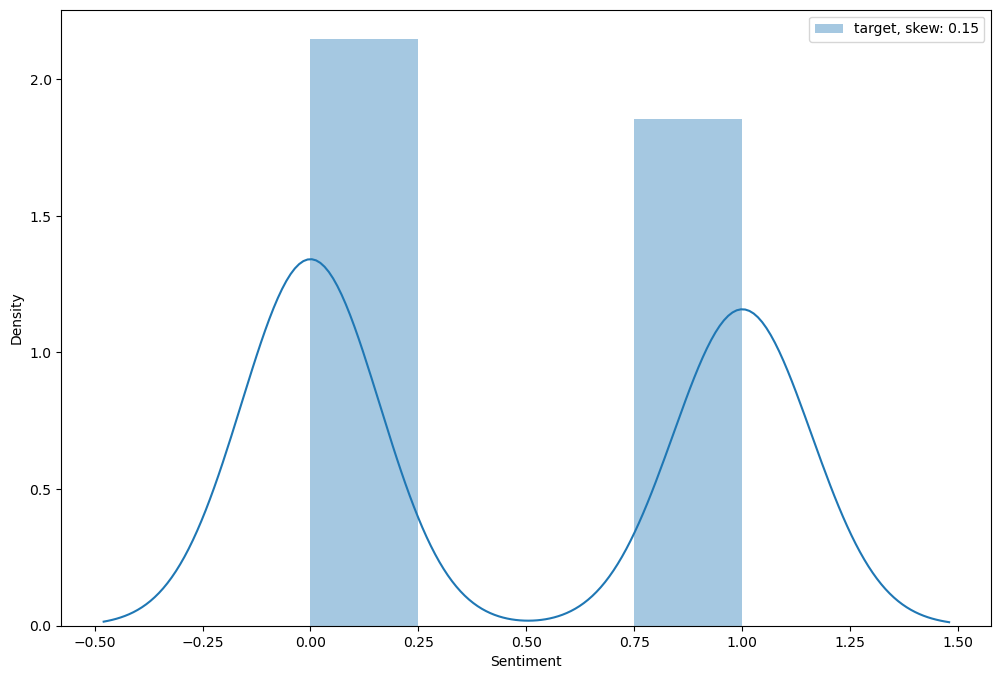

In [47]:
# Visualizing the target variable
plt.figure(figsize=(12,8))
sns.distplot(dataset_label, label=f'target, skew: {dataset_label.skew():.2f}')
plt.legend(loc='best')
plt.show()

In [48]:
dataset_label.value_counts()

0    161
1    139
Name: Sentiment, dtype: int64

## Ekstraksi Fitur dan Machine Learning

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [50]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

In [51]:
test_x

203            sinyal 4 provider name dipalembang lancar
266    provider name hooq manfaat beli kuota tonton y...
152    ayo penuh viralkan keras hashtag boikot hashta...
9      hashtag bilboard hashtag iklan provider name p...
233                                    provider name ayo
                             ...                        
114    provider name terimakasih provider name menang...
118    bonus kuota 2 gb number menit nelpon operator ...
72     hashtag boikot hashtag provider name bentuk te...
15     hashtag internet le let hashtag provider name ...
10     provider name rasa repeated puasa subuh2 sahur...
Name: ProcessedText, Length: 90, dtype: object

## load TF-IDF

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

## Naive Bayes

In [53]:
from sklearn.naive_bayes import MultinomialNB

In [54]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [55]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [56]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [57]:
classifier_nb.fit(train_x, train_label.ravel())

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('model', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100),
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3),
                                                (1, 4)]})

In [58]:
y_pred_nb_train = classifier_nb.predict(train_x)
accuracy_nb_train = accuracy_score(train_label, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)

y_pred_nb_test = classifier_nb.predict(test_x)
accuracy_nb_test = accuracy_score(test_label, y_pred_nb_test)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Training set:  0.9761904761904762
Accuracy Test set:  0.8444444444444444


In [59]:
recall_nb_train = recall_score(train_label, y_pred_nb_train, average='weighted')
print("Recall Training set: ", recall_nb_train)

recall_nb_test = recall_score(test_label, y_pred_nb_test, average='weighted')
print("Recall Test set: ", recall_nb_test)

Recall Training set:  0.9761904761904762
Recall Test set:  0.8444444444444444


In [60]:
precision_nb_train = precision_score(train_label, y_pred_nb_train, average='weighted')
print("Precision Training set: ", precision_nb_train)

precision_nb_test = precision_score(test_label, y_pred_nb_test, average='weighted')
print("Precision Test set: ", precision_nb_test)

Precision Training set:  0.976218714837454
Precision Test set:  0.8459856082497592


In [61]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

F1 Training set:  0.9761823361823362
F1 Test set:  0.8435059493883024


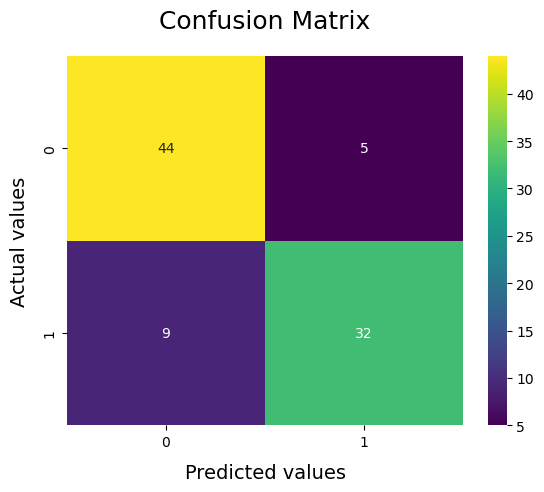

In [62]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

In [63]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', MultinomialNB(alpha=0.1))])

In [64]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 0.1
tfidf__ngram_range: (1, 1)


## KNN

In [65]:
from sklearn.neighbors import KNeighborsClassifier

In [66]:
train_x.dtype

dtype('O')

In [67]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_x_encoded = label_encoder.fit_transform(train_x)

In [68]:
test_x_encoded = label_encoder.fit_transform(test_x)

In [69]:
train_x_encoded.dtype

dtype('int32')

In [70]:
train_x_encoded = train_x_encoded.reshape(-1, 1)
# train_label = train_label.reshape(-1, 1)

In [71]:
test_x_encoded = test_x_encoded.reshape(-1, 1)

In [72]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(train_x_encoded, train_label)

KNeighborsClassifier(n_neighbors=3)

In [73]:
y_pred_knn_train = model.predict(train_x_encoded)
accuracy_knn_train = accuracy_score(train_label, y_pred_knn_train)
print("Accuracy Training set: ", accuracy_knn_train)

y_pred_knn_test = model.predict(test_x_encoded)
accuracy_knn_test = accuracy_score(test_label, y_pred_knn_test)
print("Accuracy Test set: ", accuracy_knn_test)

Accuracy Training set:  0.8476190476190476
Accuracy Test set:  0.5333333333333333


In [74]:
recall_knn_train = recall_score(train_label, y_pred_knn_train, average='weighted')
print("Recall Training set: ", recall_knn_train)

recall_knn_test = recall_score(test_label, y_pred_knn_test, average='weighted')
print("Recall Test set: ", recall_knn_test)

Recall Training set:  0.8476190476190476
Recall Test set:  0.5333333333333333


In [75]:
precision_knn_train = precision_score(train_label, y_pred_knn_train, average='weighted')
print("Precision Training set: ", precision_knn_train)

precision_knn_test = precision_score(test_label, y_pred_knn_test, average='weighted')
print("Precision Test set: ", precision_knn_test)

Precision Training set:  0.8475511695906431
Precision Test set:  0.5333333333333333


In [76]:
f1_knn_train = f1_score(train_label, y_pred_knn_train, average='weighted')
print("F1 Training set: ", f1_knn_train)

f1_knn_test = f1_score(test_label, y_pred_knn_test, average='weighted')
print("F1 Test set: ", f1_knn_test)

F1 Training set:  0.8475078307940274
F1 Test set:  0.5333333333333333


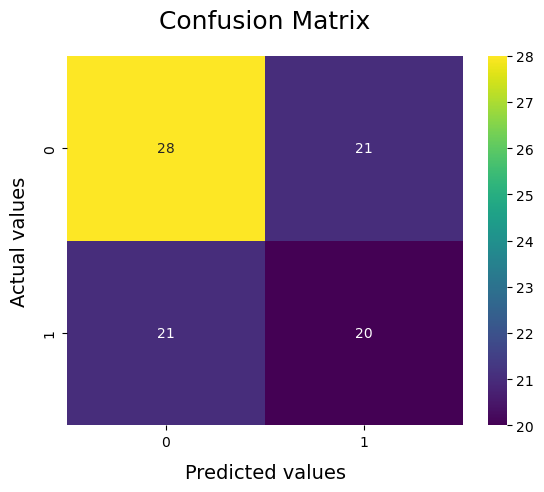

In [77]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_knn_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

## Visualisasi

In [78]:
models = [        
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
          ('KNN', accuracy_knn_train, accuracy_knn_test),
         ]

In [79]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,0.976190,0.844444
1,KNN,0.847619,0.533333


In [80]:
models_comparison = [                        
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test),
                        ('KNN', accuracy_knn_test, recall_knn_test, precision_knn_test, f1_knn_test),                   
                    ]

In [81]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.844444,0.844444,0.845986,0.843506
1,KNN,0.533333,0.533333,0.533333,0.533333


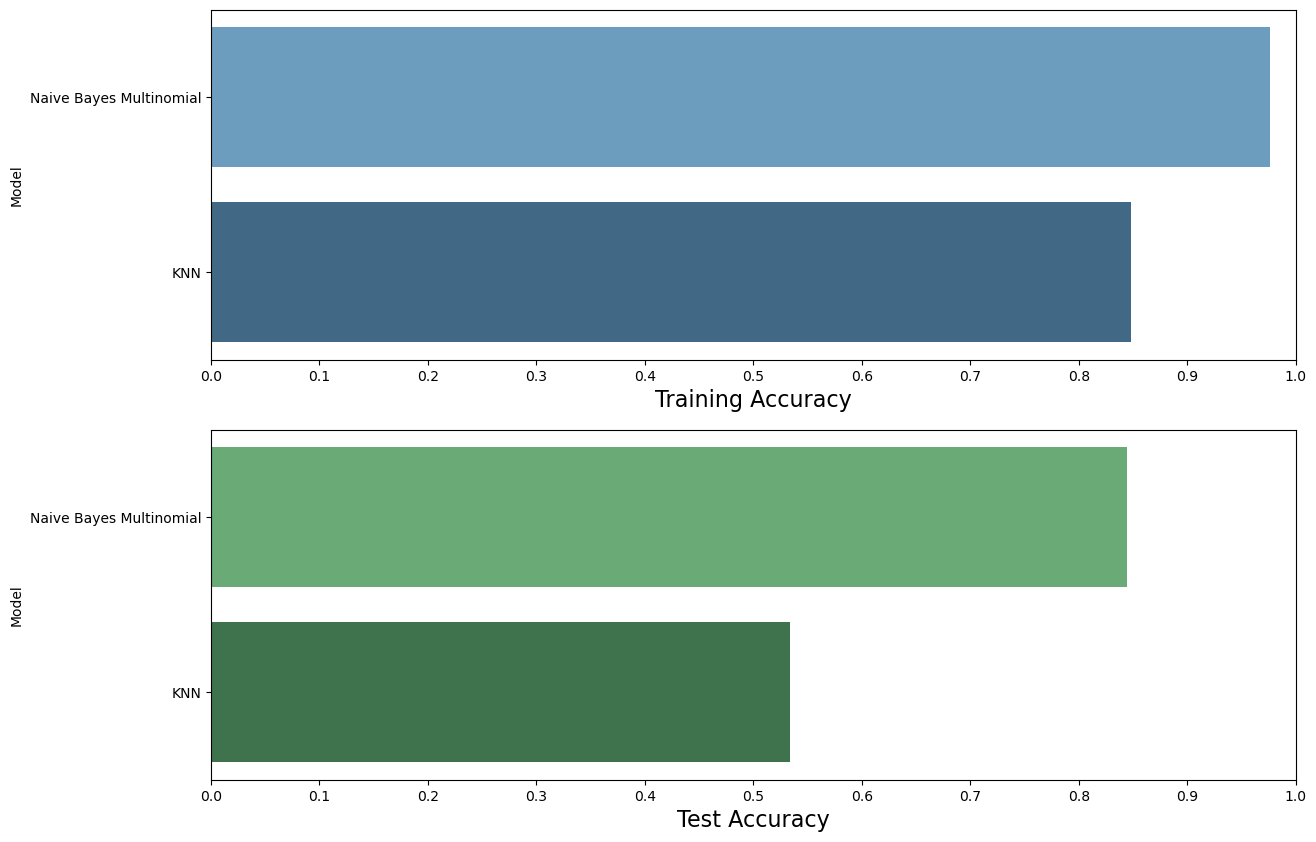

In [82]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

## simpan kedalam joblib

In [83]:
import joblib

In [86]:
# save the model to disk
joblib.dump(classifier_nb.best_estimator_, 'classifier_nb.best_estimator_.sav', compress=1)

['classifier_nb.best_estimator_.sav']